# 1.1. Our Imports:

In [1]:
import numpy as np
import pandas as pd
import os
import wfdb as wf
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, ReLU, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import random_uniform

# 1.2. Useful tools which will be used later:

In [2]:
label_encoder = LabelEncoder()
standard_scaler = StandardScaler()

# 2.1. Visualizing Data:

In [3]:
ecg_record = wf.rdsamp('mit-database/100')

print('ECG Record is:')
print(ecg_record)

print(f'\nShape of ECG Record is: {ecg_record[0].shape}')

print('\nIndex 0 of ECG Records is:')
print(ecg_record[0])

ECG Record is:
(array([[-0.145, -0.065],
       [-0.145, -0.065],
       [-0.145, -0.065],
       ...,
       [-0.675, -0.365],
       [-0.765, -0.335],
       [-1.28 ,  0.   ]]), {'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']})

Shape of ECG Record is: (650000, 2)

Index 0 of ECG Records is:
[[-0.145 -0.065]
 [-0.145 -0.065]
 [-0.145 -0.065]
 ...
 [-0.675 -0.365]
 [-0.765 -0.335]
 [-1.28   0.   ]]


# 2.2. Two Selected Leads:

In [4]:
ecg_record_MLII = ecg_record[0][:, 0]
ecg_record_V5 = ecg_record[0][:, 1]

Text(0.5, 1.0, '100 MLII')

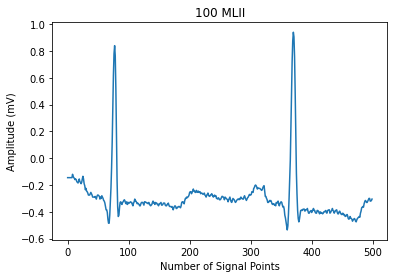

In [5]:
plt.plot(ecg_record_MLII[:500])
plt.xlabel('Number of Signal Points')
plt.ylabel('Amplitude (mV)')
plt.title('100 MLII')

Text(0.5, 1.0, '100 V5')

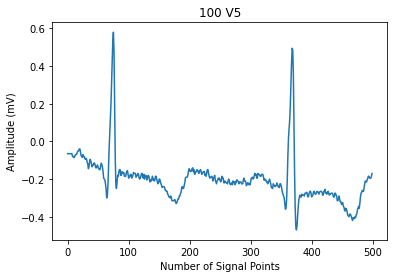

In [6]:
plt.plot(ecg_record_V5[:500])
plt.xlabel('Number of Signal Points')
plt.ylabel('Amplitude (mV)')
plt.title('100 V5')

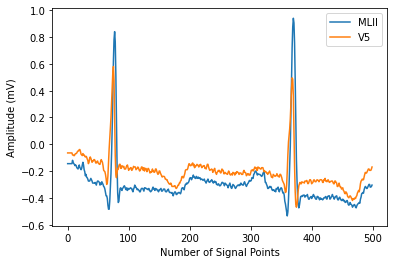

In [7]:
plt.plot(ecg_record_MLII[:500])
plt.plot(ecg_record_V5[:500])
plt.xlabel('Number of Signal Points')
plt.ylabel('Amplitude (mV)')
plt.legend(('MLII', 'V5'), loc='upper right')

# 2.3. An example of a normal heart beat:

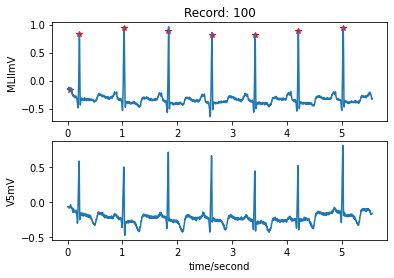

{'record_name': '100', 'extension': 'atr', 'sample': array([  18,   77,  370,  662,  946, 1231, 1515, 1809]), 'symbol': ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N'], 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0]), 'num': array([0, 0, 0, 0, 0, 0, 0, 0]), 'aux_note': ['(N\x00', '', '', '', '', '', '', ''], 'fs': 360, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels': None, 'ann_len': 8}


In [8]:
ecg_annotations = wf.rdann('mit-database/100', 'atr', sampto=2000)
ecg_record = wf.rdrecord('mit-database/100', sampto=2000)

wf.plot_wfdb(record=ecg_record, annotation=ecg_annotations, time_units='seconds')

print(ecg_annotations.__dict__)

# 2.4. An example of an abnormal heart beat:

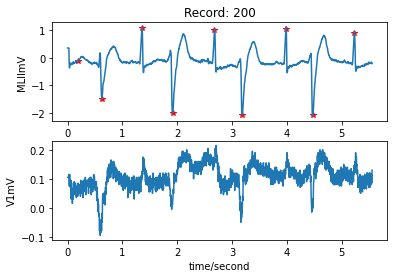

{'record_name': '200', 'extension': 'atr', 'sample': array([  67,  225,  487,  689,  964, 1147, 1433, 1610, 1882]), 'symbol': ['+', 'V', 'N', 'V', 'N', 'V', 'N', 'V', 'N'], 'subtype': array([0, 1, 0, 1, 0, 1, 0, 1, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0, 0]), 'num': array([0, 0, 0, 0, 0, 0, 0, 0, 0]), 'aux_note': ['(B\x00', '', '', '', '', '', '', '', ''], 'fs': 360, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels': None, 'ann_len': 9}


In [9]:
ecg_annotations = wf.rdann('mit-database/200', 'atr', sampto=2000)
ecg_record = wf.rdrecord('mit-database/200', sampto=2000)

wf.plot_wfdb(record=ecg_record, annotation=ecg_annotations, time_units='seconds')

print(ecg_annotations.__dict__)

# 3.1. Reading and Preprocessing Data:

In [10]:
# RECORDS file contains all the record names of the corresponding patients
records = np.loadtxt(os.path.join('mit-database/RECORDS'), dtype=str)

print('RECORDS file is:')
print(records)

print(f'\nThe length of the file is: {len(records)}')

RECORDS file is:
['100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '121' '122' '123' '124' '200'
 '201' '202' '203' '205' '207' '208' '209' '210' '212' '213' '214' '215'
 '217' '219' '220' '221' '222' '223' '228' '230' '231' '232' '233' '234']

The length of the file is: 48


In [11]:
def read_data(records):
    signals = []
    for record in records:
        ecg_record = wf.rdrecord('mit-database/' + record)
        signals.append(ecg_record.p_signal)
        
    return signals

In [12]:
signals = read_data(records)

print(f'Signals length is: {len(signals)}')

print(f'\nA random signal record: \n{signals[47]}')

Signals length is: 48

A random signal record: 
[[-0.08   0.135]
 [-0.08   0.135]
 [-0.08   0.135]
 ...
 [-0.395  0.075]
 [-0.38   0.08 ]
 [ 0.     0.   ]]


# 3.2. Two Selected Leads:

Text(0.5, 1.0, 'Lead MLII')

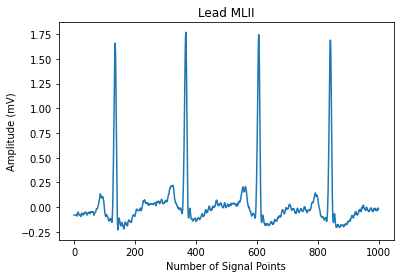

In [13]:
plt.plot(signals[47][:1000, 0])
plt.xlabel('Number of Signal Points')
plt.ylabel('Amplitude (mV)')
plt.title('Lead MLII')

Text(0.5, 1.0, 'Lead V5')

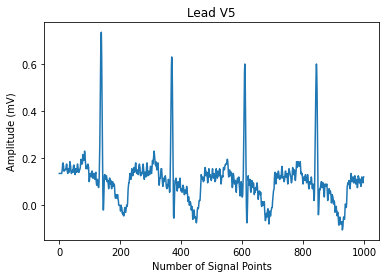

In [14]:
plt.plot(signals[47][:1000, 1])
plt.xlabel('Number of Signal Points')
plt.ylabel('Amplitude (mV)')
plt.title('Lead V5')

# 3.3. Showing all the Labels Present in our Dataset:

In [15]:
wf.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [16]:
# Valid and Invalid beats
invalid_beat = ['[', '!', ']', 'x', '(', ')', 'p', 't', 'u', '`', ''', '^', '|', '~', '+', 's', 
                'T', '*', 'D', '=',''', '@', 'B', 'a', 'J', 'S', 'r', 'F', 'e', 'j', 'n', 'f', 'Q', '?']

label_beats=['A', 'L', '/', 'V', 'R', 'E', 'N']

# 3.4. Beat Segmentation only for Lead II:

In [17]:
def segmentation(signal_MLII, beat_loc):
    window = 180
    count = 1
    x = beat_loc - window
    y = beat_loc + window
    samp = signal_MLII[x: y]
    return samp

In [18]:
signals = []
labels = []

for record in records:
    ecg_record = wf.rdrecord('mit-database/' + record)
    ecg_annotations = wf.rdann('mit-database/' + record, 'atr')
    
    annotations_sample = ecg_annotations.sample
    annotations_symbol = ecg_annotations.symbol
    
    fs = ecg_record.fs
    
    signal = ecg_record.p_signal
    signal_MLII = signal[:, 0]
    
    for i, i_sample in enumerate(annotations_sample):
        if annotations_symbol[i] in label_beats:
            label_eligible = 1
        else:
            label_eligible = 0

        segment = segmentation(signal_MLII, i_sample)
        
        if label_eligible == 1 and len(segment) == 360:
            signals.append(segment)
            labels.append(annotations_symbol[i])

In [19]:
# vstack Stacks arrays in sequence vertically (row wise).
signals = np.vstack(signals)

In [20]:
print(signals.shape)
print(signals[0])

(107141, 360)
[-0.335 -0.34  -0.315 -0.3   -0.3   -0.29  -0.295 -0.29  -0.285 -0.275
 -0.255 -0.25  -0.25  -0.265 -0.255 -0.245 -0.23  -0.245 -0.245 -0.255
 -0.255 -0.24  -0.25  -0.255 -0.245 -0.255 -0.25  -0.25  -0.265 -0.26
 -0.26  -0.265 -0.27  -0.265 -0.26  -0.275 -0.28  -0.29  -0.275 -0.27
 -0.26  -0.28  -0.28  -0.285 -0.275 -0.275 -0.265 -0.27  -0.285 -0.29
 -0.28  -0.275 -0.285 -0.28  -0.3   -0.3   -0.305 -0.295 -0.3   -0.31
 -0.31  -0.305 -0.295 -0.285 -0.285 -0.29  -0.295 -0.31  -0.29  -0.295
 -0.3   -0.305 -0.31  -0.325 -0.31  -0.3   -0.29  -0.31  -0.325 -0.33
 -0.315 -0.3   -0.305 -0.31  -0.32  -0.33  -0.325 -0.315 -0.31  -0.305
 -0.305 -0.31  -0.3   -0.305 -0.29  -0.3   -0.3   -0.305 -0.305 -0.29
 -0.28  -0.295 -0.305 -0.315 -0.305 -0.295 -0.29  -0.28  -0.27  -0.275
 -0.275 -0.27  -0.25  -0.25  -0.255 -0.225 -0.22  -0.205 -0.2   -0.205
 -0.215 -0.23  -0.22  -0.225 -0.225 -0.225 -0.23  -0.235 -0.24  -0.235
 -0.22  -0.21  -0.205 -0.245 -0.285 -0.285 -0.3   -0.31  -0.33  -0.33

# 3.5. Visualizing Segmentated Data

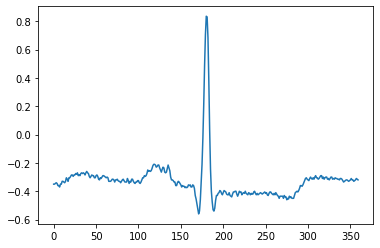

N


In [21]:
plt.plot(signals[187])
plt.show()
print(labels[187])

In [22]:
labels = pd.Series(labels)

for i, value in enumerate(labels):
    if value=='E':
        print(value)
        print(i)
        break

E
60641


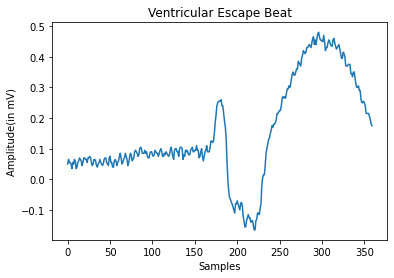

In [23]:
plt.plot(signals[60641])
plt.xlabel('Samples')
plt.ylabel('Amplitude(in mV)')
plt.title('Ventricular Escape Beat')
plt.show()

# 3.6. The Distribution of Labels:

In [24]:
labels.value_counts()

N    75011
L     8071
R     7255
V     7129
/     7023
A     2546
E      106
dtype: int64

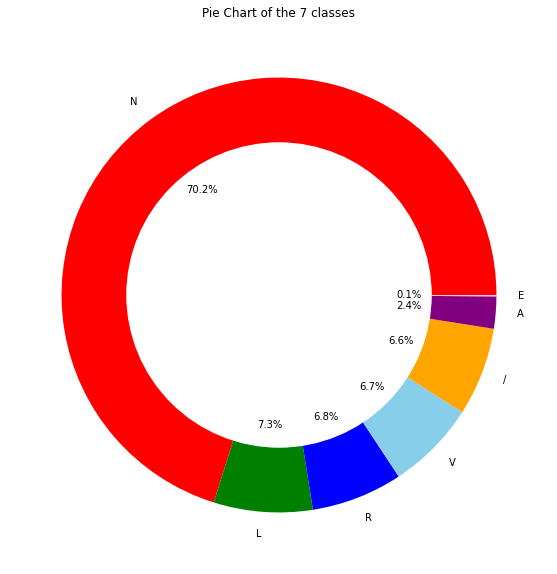

In [25]:
plt.figure(figsize=(20, 10))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie([70.01, 7.33, 6.77, 6.65, 6.56, 2.38, 0.10], labels=['N', 'L', 'R', 'V', '/', 'A', 'E'], colors=['red', 'green', 'blue', 'skyblue', 'orange', 'purple', 'pink'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Pie Chart of the 7 classes')
plt.show()

# 3.7. Resampling

In [26]:
df0 = signals[labels == '/']
df1 = signals[labels == 'A']
df2 = signals[labels == 'E']
df3 = signals[labels == 'L']
df4 = signals[labels == 'N']
df5 = signals[labels == 'R']
df6 = signals[labels == 'V']

In [27]:
print(f'The shape of df0 is: {df0.shape}')
print(f'The shape of df1 is: {df1.shape}')
print(f'The shape of df2 is: {df2.shape}')
print(f'The shape of df3 is: {df3.shape}')
print(f'The shape of df4 is: {df4.shape}')
print(f'The shape of df5 is: {df5.shape}')
print(f'The shape of df6 is: {df6.shape}')

The shape of df0 is: (7023, 360)
The shape of df1 is: (2546, 360)
The shape of df2 is: (106, 360)
The shape of df3 is: (8071, 360)
The shape of df4 is: (75011, 360)
The shape of df5 is: (7255, 360)
The shape of df6 is: (7129, 360)


In [28]:
df0_sampled = resample(df0, replace=True, n_samples=20000, random_state=16)
df1_sampled = resample(df1, replace=True, n_samples=20000, random_state=16)
df2_sampled = resample(df2, replace=True, n_samples=20000, random_state=16)
df3_sampled = resample(df3, replace=True, n_samples=20000, random_state=16)
df4_sampled = resample(df4, replace=True, n_samples=20000, random_state=16)
df5_sampled = resample(df5, replace=True, n_samples=20000, random_state=16)
df6_sampled = resample(df6, replace=True, n_samples=20000, random_state=16)

In [29]:
print(f'The shape of df0_sampled is: {df0_sampled.shape}')
print(f'The shape of df1_sampled is: {df1_sampled.shape}')
print(f'The shape of df2_sampled is: {df2_sampled.shape}')
print(f'The shape of df3_sampled is: {df3_sampled.shape}')
print(f'The shape of df4_sampled is: {df4_sampled.shape}')
print(f'The shape of df5_sampled is: {df5_sampled.shape}')
print(f'The shape of df6_sampled is: {df6_sampled.shape}')

The shape of df0_sampled is: (20000, 360)
The shape of df1_sampled is: (20000, 360)
The shape of df2_sampled is: (20000, 360)
The shape of df3_sampled is: (20000, 360)
The shape of df4_sampled is: (20000, 360)
The shape of df5_sampled is: (20000, 360)
The shape of df6_sampled is: (20000, 360)


In [30]:
X = []
X.extend(df0_sampled)
X.extend(df1_sampled)
X.extend(df2_sampled)
X.extend(df3_sampled)
X.extend(df4_sampled)
X.extend(df5_sampled)
X.extend(df6_sampled)

In [31]:
print(f'The length of X is: {len(X)}')

The length of X is: 140000


In [32]:
y_0 = ['/'] * len(df0_sampled)
y_1 = ['A'] * len(df1_sampled)
y_2 = ['E'] * len(df2_sampled)
y_3 = ['L'] * len(df3_sampled)
y_4 = ['N'] * len(df4_sampled)
y_5 = ['R'] * len(df5_sampled)
y_6 = ['V'] * len(df6_sampled)

In [33]:
y = []
y.extend(y_0)
y.extend(y_1)
y.extend(y_2)
y.extend(y_3)
y.extend(y_4)
y.extend(y_5)
y.extend(y_6)

In [34]:
print(f'The length of y is: {len(y)}')

The length of y is: 140000


# 3.8. The Distribution of Labels after Resampling:

In [35]:
dummy = pd.DataFrame(y, columns=['Labels'])
print('Value distribution:\n')
count = dummy['Labels'].value_counts()
percent = dummy['Labels'].value_counts(normalize=True).mul(100).round(2)
print(pd.concat([count, percent], axis=1, keys=['Counts', 'Percent']))

Value distribution:

   Counts  Percent
/   20000    14.29
A   20000    14.29
E   20000    14.29
L   20000    14.29
N   20000    14.29
R   20000    14.29
V   20000    14.29


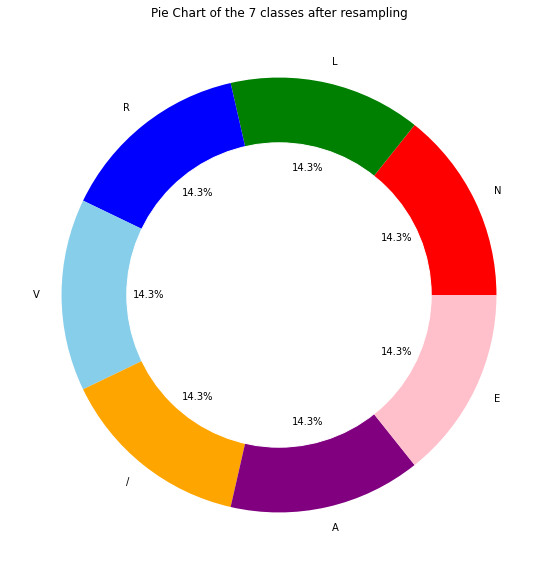

In [36]:
plt.figure(figsize=(20,10))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie([14.29, 14.29, 14.29, 14.29, 14.29, 14.29, 14.29], labels=['N', 'L', 'R', 'V', '/', 'A', 'E'], colors=['red', 'green', 'blue', 'skyblue', 'orange', 'purple', 'pink'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Pie Chart of the 7 classes after resampling')
plt.show()

# 3.9. Standarization of the Signals:

In [37]:
X_scaled = standard_scaler.fit_transform(X)

# 3.10. Splitting Data into Train and Test Set:

In [38]:
y = label_encoder.fit_transform(y)

In [39]:
label_encoder.classes_

array(['/', 'A', 'E', 'L', 'N', 'R', 'V'], dtype='<U1')

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

# 3.11. The Distribution of Labels after splitting:

In [41]:
dummy = pd.DataFrame(y_train, columns=['Labels'])
print('Value distribution for y_train:\n')
count = dummy['Labels'].value_counts()
percent = dummy['Labels'].value_counts(normalize=True).mul(100).round(2)
print(pd.concat([count, percent], axis=1, keys=['Counts', 'Percent']))

Value distribution for y_train:

   Counts  Percent
5   16000    14.29
3   16000    14.29
4   16000    14.29
2   16000    14.29
1   16000    14.29
6   16000    14.29
0   16000    14.29


In [42]:
dummy = pd.DataFrame(y_test, columns=['Labels'])
print('Value distribution for y_test:\n')
count = dummy['Labels'].value_counts()
percent = dummy['Labels'].value_counts(normalize=True).mul(100).round(2)
print(pd.concat([count, percent], axis=1, keys=['Counts', 'Percent']))

Value distribution for y_test:

   Counts  Percent
0    4000    14.29
1    4000    14.29
4    4000    14.29
6    4000    14.29
3    4000    14.29
5    4000    14.29
2    4000    14.29


# 3.12. Conversion the Data into NumPy Arrays:

In [43]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [44]:
print(f'The shape of x_train is: {x_train.shape}')
print(f'The shape of y_train is: {y_train.shape}')
print(f'The shape of x_test is: {x_test.shape}')
print(f'The shape of y_test is: {y_test.shape}')

The shape of x_train is: (112000, 360)
The shape of y_train is: (112000,)
The shape of x_test is: (28000, 360)
The shape of y_test is: (28000,)


# 4.1. Training and Classification Time:

# 4.2. Training a SVM Model:

In [45]:
model = SVC(C=1.0, kernel='rbf', degree=3, verbose=True)
model.fit(x_train, y_train.flatten())

[LibSVM]

SVC(verbose=True)

# 4.3. Evaluation of SVM Model:

In [50]:
y_pred = model.predict(x_test)

In [51]:
# Accuracy of SVM Model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9816428571428572

In [52]:
# Recall of SVM Model
recall = recall_score(y_test, y_pred, average='macro')
recall

0.981642857142857

In [53]:
# Precision of SVM Model
precision = precision_score(y_test, y_pred, average='macro')
precision

0.9819771448370836

In [54]:
# F1-Score of SVM Model
f1 = f1_score(y_test, y_pred, average='macro')
f1

0.981694779505576

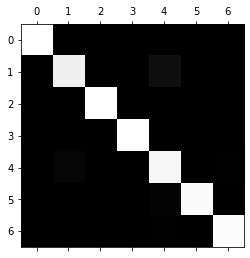

In [55]:
# Confusion Matrix of SVM Model
plt.matshow(confusion_matrix(y_test, y_pred, normalize='true'), cmap='gray')
plt.show()

# 4.4. Training a Logistic Regression Model:

In [56]:
model = LogisticRegression(verbose=3, random_state=16, solver='lbfgs', max_iter=200)
model.fit(x_train, y_train.flatten())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.6s finished


LogisticRegression(max_iter=200, random_state=16, verbose=3)

# 4.5. Evaluation of Logistic Regression Model:

In [57]:
y_pred = model.predict(x_test)

In [58]:
# Accuracy of Logistic Regression Model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.8895

In [59]:
# Recall of Logistic Regression Model
recall = recall_score(y_test, y_pred, average='macro')
recall

0.8895

In [60]:
# Precision of Logistic Regression Model
precision = precision_score(y_test, y_pred, average='macro')
precision

0.8894031743588819

In [61]:
# F1-Score of Logistic Regression Model
f1 = f1_score(y_test, y_pred, average='macro')
f1

0.8893023761242558

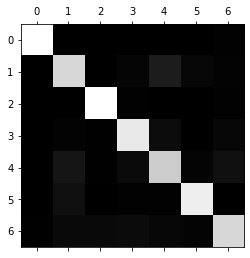

In [62]:
# Confusion Matrix of Logistic Regression Model
plt.matshow(confusion_matrix(y_test, y_pred, normalize='true'), cmap='gray')
plt.show()

# 4.6. Training a MLP Model:

In [63]:
input = Input((360,))

x = Dense(32, kernel_initializer=random_uniform, kernel_regularizer=l2(0.0001))(input)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.1)(x)

x = Dense(64, kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.15)(x)

x = Dense(128, kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.2)(x)

x = Dense(256, kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.25)(x)

x = Dense(512, kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)

output = Dense(7, activation='softmax')(x)

In [64]:
model = Model(inputs=input, outputs=output)

model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(lr=5e-1, momentum=0.1), metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 360)]             0         
                                                                 
 dense (Dense)               (None, 32)                11552     
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                             

c:\program files\python37\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [65]:
es = EarlyStopping(monitor='val_loss', patience=8, mode='auto', verbose=1)

In [66]:
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[es])

Epoch 1/10
1400/1400 [==============================] - 40s 21ms/step - loss: 0.6207 - accuracy: 0.8384 - val_loss: 0.4814 - val_accuracy: 0.8907
Epoch 2/10
1400/1400 [==============================] - 28s 20ms/step - loss: 0.3636 - accuracy: 0.9159 - val_loss: 0.2108 - val_accuracy: 0.9610
Epoch 3/10
1400/1400 [==============================] - 28s 20ms/step - loss: 0.3195 - accuracy: 0.9296 - val_loss: 0.1938 - val_accuracy: 0.9694
Epoch 4/10
1400/1400 [==============================] - 28s 20ms/step - loss: 0.2970 - accuracy: 0.9366 - val_loss: 0.1894 - val_accuracy: 0.9696
Epoch 5/10
1400/1400 [==============================] - 27s 19ms/step - loss: 0.2784 - accuracy: 0.9405 - val_loss: 0.1701 - val_accuracy: 0.9730
Epoch 6/10
1400/1400 [==============================] - 27s 19ms/step - loss: 0.2686 - accuracy: 0.9440 - val_loss: 0.2318 - val_accuracy: 0.9510
Epoch 7/10
1400/1400 [==============================] - 27s 19ms/step - loss: 0.2520 - accuracy: 0.9477 - val_loss: 0.1612 -

# 4.7. Evaluation of MLP Model:

In [72]:
y_pred = model.predict(x_test)

In [73]:
y_pred = np.argmax(y_pred, axis=1)

In [74]:
# Accuracy of MLP Model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9781785714285715

In [75]:
# Recall of MLP Model
recall = recall_score(y_test, y_pred, average='macro')
recall

0.9781785714285716

In [76]:
# Precision of MLP Model
precision = precision_score(y_test, y_pred, average='macro')
precision

0.9781095269047017

In [77]:
# F1-Score of MLP Model
f1 = f1_score(y_test, y_pred, average='macro')
f1

0.978111473963267

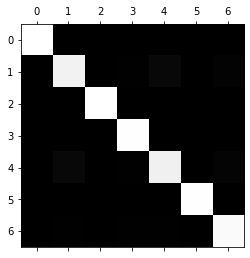

In [78]:
# Confusion Matrix of MLP Model
plt.matshow(confusion_matrix(y_test, y_pred, normalize='true'), cmap='gray')
plt.show()

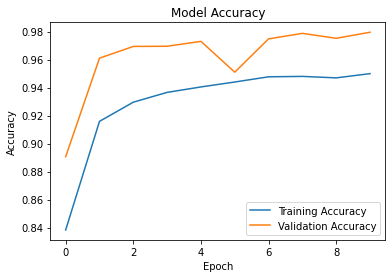

In [79]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()

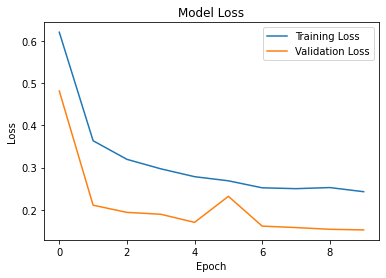

In [80]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')
plt.show()